We solve the Neoclassical Growth Model with Capital(k) and Productivity (y):
\begin{align}
  \rho V(k,y) &= \max_{c} [ u(c) +  \partial_k V (F(k,y)-\delta k - c) + \mu(y)\partial_y V(k,y) + \frac{\sigma^2(y)}{2} \partial_{yy}  V(k,y) ] \\
  &u(c) = \frac{c^{1-\sigma}}{1-\sigma}, ~~~
  F(k)=y k^\alpha, ~~~
  dy_t=\mu d_t+\sigma dz_t
\end{align}


In [1]:
import numpy as np

import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
x = np.linspace(1, 10, num=10)
inputs = tf.constant(x)
def function(x):
  return x**2

with tf.GradientTape() as t: #(persistent=True)
    t.watch(inputs)
    y = function(inputs)

dy_dx = t.gradient(y, inputs).numpy()
print(dy_dx)

[ 2.  4.  6.  8. 10. 12. 14. 16. 18. 20.]


In [3]:
x = np.linspace(1, 10, num=10)
inputs = tf.Variable(x) 
with tf.GradientTape() as t1:
    with tf.GradientTape() as t2:
        y = function(inputs)
#      y = inputs * inputs * inputs
    dy_dx = t2.gradient(y, inputs)
d2y_dx2 = t1.gradient(dy_dx, inputs).numpy()
print(d2y_dx2)

[2. 2. 2. 2. 2. 2. 2. 2. 2. 2.]


In [4]:
sigma = 2 # 1 changes to log utility
alpha = 0.3
delta = 0.05
rho = 0.05

In [5]:
# ORNSTEIN-UHLENBECK PROCESS dlog(z) = -theta*log(z)dt + sig2*dW
# STATIONARY DISTRIBUTION IS log(z) ~ N(0,Var) WHERE Var = sig2/(2*theta)
Var = 0.07
zmean = np.exp(Var/2) #MEAN OF LOG-NORMAL DISTRIBUTION N(0,Var)
Corr = 0.9
theta = -np.log(Corr) # this is mu
sig2 = 2*theta*Var # this is sigma

ymin = zmean*0.8
ymax = zmean*1.2

#DRIFT (FROM ITO'S LEMMA)
def mu(y):
    return (-theta*np.log(y) + sig2/2)*y 

# VARIANCE (FROM ITO'S LEMMA)
def sigma2(y):
    return sig2*y**2

In [6]:
kss = (alpha/(rho+delta))**(1/(1-alpha))
kmin = 0.001*kss
kmax = 2*kss

In [7]:
train_num = 100
# x_train = np.random.uniform(kmin,kmax,(train_num,1))
x1_train = np.linspace(kmin, kmax, num=train_num).reshape(train_num,1)
x1_train.shape

x2_train = np.linspace(ymin, ymax, num=train_num).reshape(train_num,1)
x2_train.shape

(100, 1)

In [8]:
def build_model():
  model = keras.Sequential([
    layers.Dense(64, activation='tanh', input_shape=[2]), #use_bias=True
    layers.Dense(64, activation='tanh'), #use_bias=False     
    layers.Dense(64, activation='tanh'), #use_bias=False
#     layers.Dense(16, activation='relu'), #use_bias=False     
#     layers.Dense(8, activation='relu'), #use_bias=False 
#     layers.Dense(4, activation='relu'), #use_bias=False 
#     layers.Dense(2, activation='relu'), #use_bias=False   
    layers.Dense(1) #,kernel_constraint=keras.constraints.NonNeg()
  ])

  optimizer = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
#   optimizer = tf.keras.optimizers.RMSprop(0.001)

  model.compile(loss='mse',
                optimizer=optimizer,
                )
  return model

In [9]:
model = build_model()

In [10]:
model.summary()
# model.get_weights() 

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                192       
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_2 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 65        
Total params: 8,577
Trainable params: 8,577
Non-trainable params: 0
_________________________________________________________________


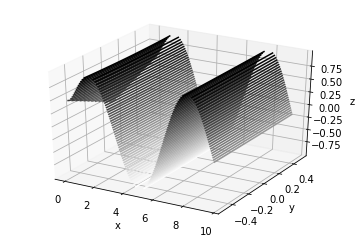

In [12]:
from mpl_toolkits import mplot3d

def f(x, y):
    return np.sin(np.sqrt(x ** 2 + y ** 2))

X, Y = np.meshgrid(x1_train, x2_train)
Z = f(X, Y)

fig = plt.figure()
ax = plt.axes(projection='3d')
ax.contour3D(X, Y, Z, 50, cmap='binary')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z');

In [13]:
z_train = x1_train**2 + x2_train**2
x_train = np.concatenate((x1_train, x2_train), axis=1)
model.fit( x_train, z_train, epochs=50,validation_split = 0.2, verbose=1 ) # ,batch_size=5000

Train on 80 samples, validate on 20 samples
Epoch 1/50
80/80 [==============================] - 0s 5ms/sample - loss: 708.2903 - val_loss: 5711.8135
Epoch 2/50
80/80 [==============================] - 0s 124us/sample - loss: 658.5879 - val_loss: 5507.4385
Epoch 3/50
80/80 [==============================] - 0s 190us/sample - loss: 610.8758 - val_loss: 5328.9077
Epoch 4/50
80/80 [==============================] - 0s 195us/sample - loss: 572.0285 - val_loss: 5173.5967
Epoch 5/50
80/80 [==============================] - 0s 139us/sample - loss: 537.6288 - val_loss: 5039.9507
Epoch 6/50
80/80 [==============================] - 0s 209us/sample - loss: 510.5226 - val_loss: 4922.1201
Epoch 7/50
80/80 [==============================] - 0s 183us/sample - loss: 485.0833 - val_loss: 4818.1162
Epoch 8/50
80/80 [==============================] - 0s 239us/sample - loss: 464.4115 - val_loss: 4725.3164
Epoch 9/50
80/80 [==============================] - 0s 227us/sample - loss: 446.2647 - val_loss: 4644.

22.3967931825873


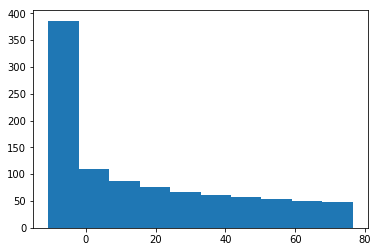

In [16]:
x1_test = np.linspace(kmin,kmax,num=1000).reshape(1000,1)
x2_test = np.linspace(ymin,ymax,num=1000).reshape(1000,1)

x_test = np.concatenate((x1_test, x2_test), axis=1)

z_test = x1_test**2 + x2_test**2

error = z_test.reshape(1000,1) - model.predict([x_test])

print(np.mean(abs(error)))

plt.hist(error, bins=10) 
plt.show()

In [22]:
update = 1
dt = 5*1e-2
criteria = 1e-2
converge_error = 10

In [23]:
# for update in range(update):
while converge_error > criteria and update<100:
        value = model.predict([x_train])
#         print(type(value))

        with tf.GradientTape() as t: #(persistent=True)
            t.watch(inputs)
            output = model(inputs)
            
        derivative = t.gradient(output, inputs).numpy()
#         print(derivative)

        for i in range(train_num):
            derivative[i] = np.maximum(derivative[i], 1e-4)
            
        # with log utility function
#         HJB = np.log(1/derivative)+derivative*((train)**alpha-delta*train-1/derivative)-rho*value

        # with sigma=2 CRRA utility function
        HJB = (1/np.sqrt(derivative))**(1-sigma)/(1-sigma)+derivative*((x_train)**alpha-delta*x_train-1/np.sqrt(derivative))-rho*value
#         print(HJB)
        value += dt*HJB
        model.fit( x_train, value,  epochs=10, validation_split = 0.2, verbose=0 )
        
        update += 1
        converge_error = np.mean(abs(HJB))
        print(update,  max(abs(HJB)), np.mean(abs(HJB)))

2 [0.71915919] 0.038547629983768025
3 [0.22566654] 0.038201263554644066
4 [0.50637712] 0.03849247981167963
5 [0.32767914] 0.038816904243587406
6 [0.22355619] 0.03920040265798001
7 [0.19756393] 0.03910694034474036
8 [0.25784666] 0.03915798355421414
9 [0.19344839] 0.039770202684689226
10 [0.65822088] 0.03996148828430986
11 [0.18748841] 0.0394542135742916
12 [0.18984037] 0.03952972895817758
13 [0.18984872] 0.03965958378020282
14 [0.29382408] 0.039752751864286826
15 [0.41045974] 0.0393634412323338
16 [0.19916504] 0.03938575904804079
17 [0.20304017] 0.03986685383180474
18 [0.71270359] 0.040045077401087266
19 [0.21274118] 0.03984166596457437
20 [0.33319853] 0.04064079417422364
21 [0.30321083] 0.041340813101480016
22 [0.33915106] 0.04123246262690722
23 [0.26110155] 0.04107573080673904
24 [0.72261787] 0.04064689005338942
25 [0.35578976] 0.040282241545962987
26 [0.26369] 0.040393391853870295
27 [0.28123149] 0.040327109542787135
28 [0.34978646] 0.04045957920207709
29 [0.28509353] 0.0409542133210

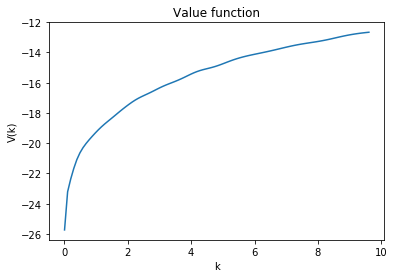

In [17]:
x = np.linspace(kmin, kmax, num=100)
y = model.predict([x])


plt.plot(x,y)

plt.xlabel('k')
plt.ylabel('V(k)')
plt.title('Value function')
plt.show()

In [19]:
from tensorflow.keras.models import load_model

model.save('NCG_TD.h5')  # creates a HDF5 file 'my_model.h5'
# del model  # deletes the existing model

# returns a compiled model
# identical to the previous one
# model = load_model('my_model.h5')